# Sklearn Classification

## Data Preparation

In [7]:
from data_prepare import MultiFormatDataLoader
# Replace the data directory with your actual data path
data_dir = './data'
multi_dataloader = MultiFormatDataLoader(data_dir, batch_size=2048)
multi_dataloader.load_data()

Loading data...


Loading files: 100%|██████████| 8550/8550 [00:06<00:00, 1311.36it/s]


Loaded 8550 samples


In [9]:
multi_dataloader.split_data()

In [10]:
x_train, y_train = multi_dataloader.get_sklearn_data(split='train')
x_val, y_val = multi_dataloader.get_sklearn_data(split='val')
x_test, y_test = multi_dataloader.get_sklearn_data(split='test')

## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(x_train, y_train)
y_pred_logreg = logreg.predict(x_test)
acc_logreg = accuracy_score(y_test, y_pred_logreg)
print("Logistic Regression accuracy:", acc_logreg)

Logistic Regression accuracy: 0.4994152046783626


## KNN

KNN accuracy for n_neighbors=1: 0.5976608187134503
KNN accuracy for n_neighbors=2: 0.6619883040935672
KNN accuracy for n_neighbors=3: 0.6011695906432749
KNN accuracy for n_neighbors=4: 0.6444444444444445
KNN accuracy for n_neighbors=5: 0.6198830409356725
KNN accuracy for n_neighbors=6: 0.6514619883040935
KNN accuracy for n_neighbors=7: 0.6152046783625731
KNN accuracy for n_neighbors=8: 0.6502923976608187
KNN accuracy for n_neighbors=9: 0.6152046783625731
KNN accuracy for n_neighbors=10: 0.6444444444444445


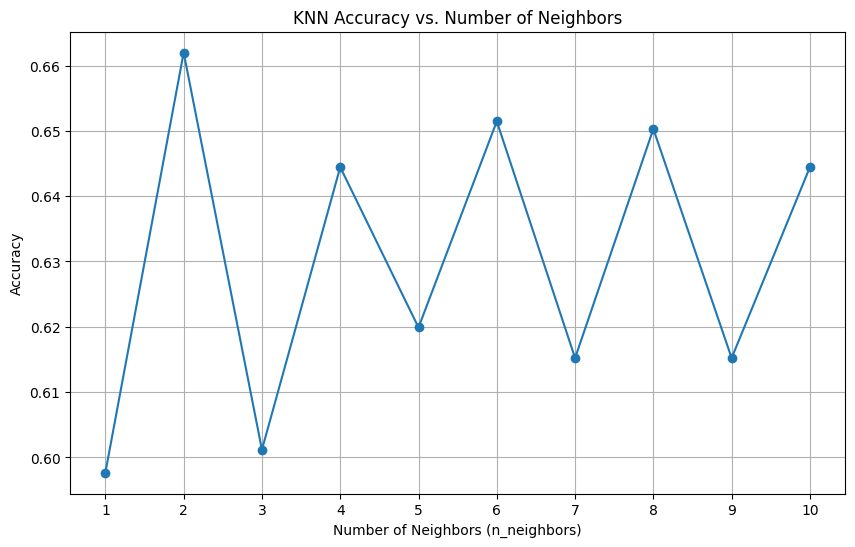

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

# Test different n_neighbors
accuracies = []
n_neighbors_range = range(1, 11)
for n in n_neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"KNN accuracy for n_neighbors={n}: {acc}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors_range, accuracies, marker='o', linestyle='-')
plt.title('KNN Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Accuracy')
plt.xticks(n_neighbors_range)
plt.grid(True)
plt.show()

## SVM

In [ ]:
# TOO SLOW for high-dimensional data

# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score

# svm_pca = SVC(kernel='linear', random_state=42)
# svm_pca.fit(X_flat_train, y_train)
# y_pred_svm_pca = svm_pca.predict(X_flat_test)
# acc_svm_pca = accuracy_score(y_test, y_pred_svm_pca)
# print(f"SVM (with PCA, 128 components) accuracy: {acc_svm_pca}")

# svm_rbf = SVC(kernel='rbf', random_state=42)
# svm_rbf.fit(X_flat_train, y_train)
# y_pred_svm_rbf = svm_rbf.predict(X_flat_test)
# acc_svm_rbf = accuracy_score(y_test, y_pred_svm_rbf)
# print("SVM (RBF kernel) accuracy:", acc_svm_rbf)

## Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest accuracy:", acc_rf)


Random Forest accuracy: 0.7204678362573099


Best parameters: {'max_depth': 40, 'n_estimators': 400}
Best cross-validation accuracy: 0.776608187134503
Test accuracy with best parameters: 0.7637426900584795


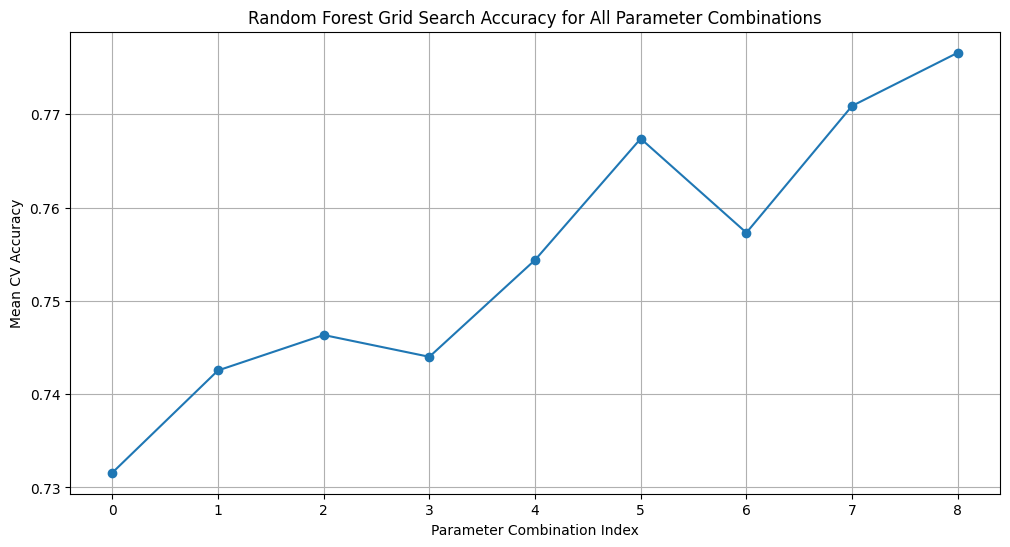

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [10, 20, 40]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Train the model with the best parameters and evaluate
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(x_test)
acc_best_rf = accuracy_score(y_test, y_pred_best_rf)
print("Test accuracy with best parameters:", acc_best_rf)

# Visualize the grid search results
results = grid_search.cv_results_
scores = results['mean_test_score']
params = results['params']

plt.figure(figsize=(12, 6))
plt.plot(range(len(scores)), scores, marker='o')
plt.title('Random Forest Grid Search Accuracy for All Parameter Combinations')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Mean CV Accuracy')
plt.grid(True)
plt.show()